# Plot effect of input and adjacency normalization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("./rc-gfd.mplstyle")

In [25]:
def open_dataset(dirname, random_state):
    
        
    experiment = os.path.basename(dirname)
    experiment = experiment.replace("output-","")
    
    tspin = "notspin" not in experiment
    experiment = experiment.replace("notspin-","")
    
    experiment = experiment.replace("-","\n")
    xds = xr.open_dataset(f"{dirname}/random-state-{rs:02d}/results.nc", chunks="auto")
    
    xds = xds.expand_dims({
        "experiment"   : [experiment],
        "random_state" : [rs],
        "tspin"        : [tspin]
    })
    
    with xr.set_options(keep_attrs=True):
        for key in ["prediction","truth", "clim_std"]:
            xds[key] = xds[key] * 3.67
            if key != "clim_std":
                xds[key] = xds[key] + 2.42
            
        se = (xds["prediction"]-xds["truth"])/xds["clim_std"]
        xds["nrmse"] = (se**2).mean("x")
        xds["vpt"] = xds["time"].where((xds["nrmse"]>xds.vpt_threshold) & (xds["time"]>=0)).min('time')
            
    return xds

In [35]:
def boxplot(xds, ax=None, figsize=None, **kwargs):
    
    fig = None
    if ax is None:
        fig, ax = plt.subplots(constrained_layout=True, figsize=figsize)
        
    sns.boxplot(
        data=xds["vpt"].to_dataframe().reset_index(),
        ax=ax,
        **kwargs
    )
    for key in ["right", "top"]:
        ax.spines[key].set_visible(False)
    ax.set(ylabel="Lyapunov VPT",
           xlabel="",
          )
    return fig, ax

In [36]:
def violinplot(xds, ax=None, **kwargs):
    
    fig = None
    if ax is None:
        fig, ax = plt.subplots(constrained_layout=True)
        
    split = "hue" in kwargs
    sns.violinplot(
        data=xds["vpt"].to_dataframe().reset_index(),
        ax=ax,
        split=split,
        **kwargs
    )
    for key in ["right", "top"]:
        ax.spines[key].set_visible(False)
    ax.set(ylabel="Lyapunov VPT",
           xlabel="",
          )
    return fig, ax

## Data normalization

In [31]:
dslist = []
main_dir = "/contrib/Tim.Smith/qgrc-teachers/simple/test-adjacency-stuff/"
dirlist = [main_dir + d for d in [
        "output-svd-normmaxmin", "output-svd-normstd"
    ]
]
for dirname in dirlist:
    dslist2 = []
    for rs in range(10):
        dslist2.append(open_dataset(dirname, rs))
    dslist.append(xr.concat(dslist2,dim="random_state"))
    
ds6d = xr.concat(dslist, dim="experiment")

/contrib/Tim.Smith/miniconda3/envs/ddc10/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


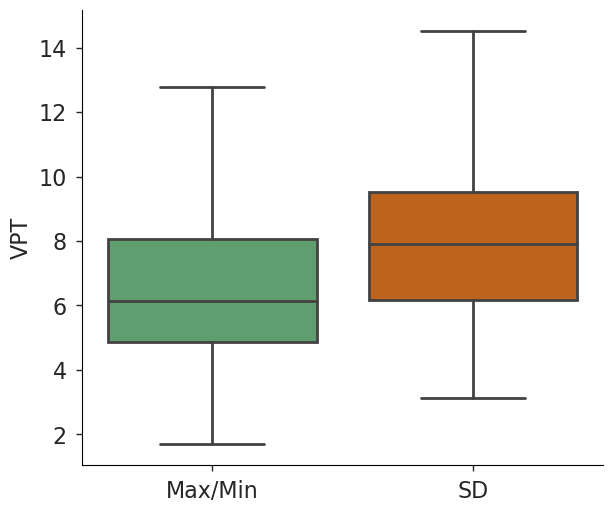

In [42]:
fig, ax = boxplot(
    ds6d,
    x="experiment",
    y="vpt",
    showfliers=False,
    figsize=(6,5),
       )
ax.set(ylabel="VPT")
ax.set(xticklabels=["Max/Min", "SD"], yticks=np.arange(2,16,2))
fig.savefig("../figures/data-normalization.pdf", bbox_inches="tight")

## Matrix normalization with 6D system (and also training spinup discard)

In [ ]:
dslist = []
main_dir = "/contrib/Tim.Smith/qgrc-teachers/simple/test-input-and-adjacency-clean/"
dirlist = [main_dir+d for d in os.listdir(main_dir) if "output" in d and "notspin" not in d]
dirlist2 = [main_dir+d for d in os.listdir(main_dir) if "output" in d and "notspin" in d]
for dirname in dirlist:
    dslist2 = []
    for rs in range(10):
        dslist2.append(open_dataset(dirname, rs))
    dslist.append(xr.concat(dslist2,dim="random_state"))
    
ds1 = xr.concat(dslist, dim="experiment")
dslist = []
for dirname in dirlist2:
    dslist2 = []
    for rs in range(10):
        dslist2.append(open_dataset(dirname, rs))
    dslist.append(xr.concat(dslist2,dim="random_state"))
ds2 = xr.concat(dslist, dim="experiment")
ds6d = xr.concat([ds1,ds2], dim='tspin')

/contrib/Tim.Smith/miniconda3/envs/ddc10/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


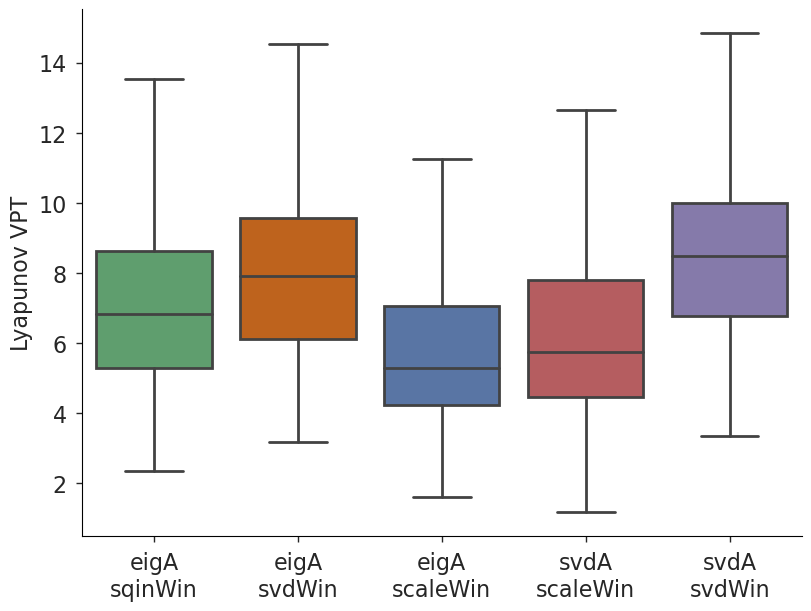

In [8]:
boxplot(
    ds6d.sel(tspin=False),
    x="experiment",
    y="vpt",
    #hue="tspin",
    showfliers=False,
);

## Show impact of matrix normalization with 20D System

In [43]:
def open_dataset(dirname, reservoir_dimension, random_state):
        
    experiment = os.path.basename(dirname)
    experiment = experiment.replace("output-","")
    
    tspin = "notspin" not in experiment
    experiment = experiment.replace("notspin-","")
    
    experiment = experiment.replace("-","\n")
    xds = xr.open_dataset(f"{dirname}/reservoir-{reservoir_dimension:04d}/random-state-{rs:02d}/results.nc", chunks="auto")
    
    xds = xds.expand_dims({
        "experiment"   : [experiment],
        "random_state" : [rs],
        "reservoir_dimension": [reservoir_dimension]
    })
    
    with xr.set_options(keep_attrs=True):
        for key in ["prediction","truth", "clim_std"]:
            xds[key] = xds[key] * 3.67
            if key != "clim_std":
                xds[key] = xds[key] + 2.42
            
        se = (xds["prediction"]-xds["truth"])/xds["clim_std"]
        xds["nrmse"] = (se**2).mean("x")
        xds["vpt"] = xds["time"].where((xds["nrmse"]>xds.vpt_threshold) & (xds["time"]>=0)).min('time')
            
    return xds

In [44]:
dslist = []
main_dir = "/contrib/Tim.Smith/qgrc-teachers/simple/test-increasing-reservoir/"
dirlist = [main_dir+d for d in os.listdir(main_dir) if "output" in d]
for dirname in dirlist:
    dslist2 = []
    for reservoir_dimension in [600, 1200, 4800]:
        dslist3 = []
        for rs in range(10):
            dslist3.append(open_dataset(dirname,  reservoir_dimension=reservoir_dimension, random_state=rs))
        dslist2.append(xr.concat(dslist3,dim="random_state"))
    dslist.append(xr.concat(dslist2,dim="reservoir_dimension"))
ds = xr.concat(dslist, dim="experiment")

[Text(0, 0.5, 'VPT')]

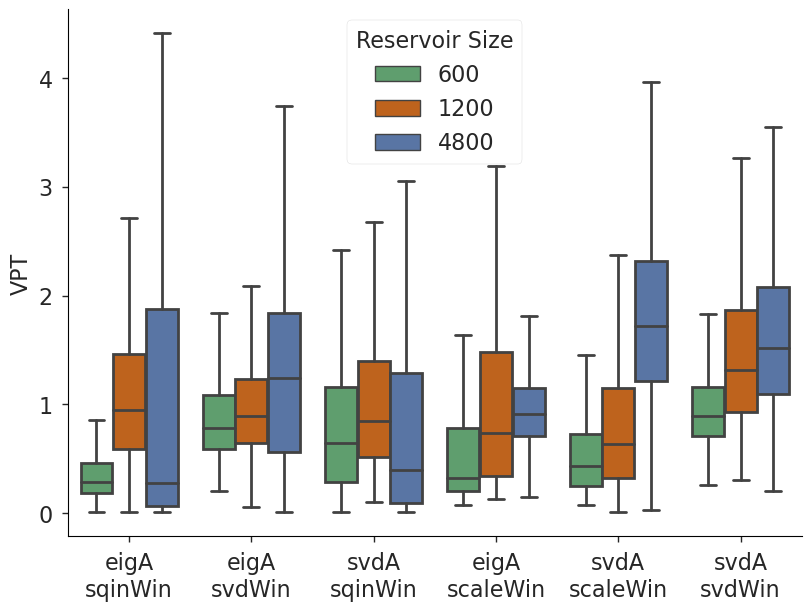

In [45]:
fig, ax = boxplot(
    ds,
    x="experiment",
    y="vpt",
    hue="reservoir_dimension",
    showfliers=False,
);
ax.legend(title=r"Reservoir Size", frameon=True)
ax.set(ylabel="VPT")
#fig.savefig("../figures/)

Reduce some of these that are out of scope for the paper

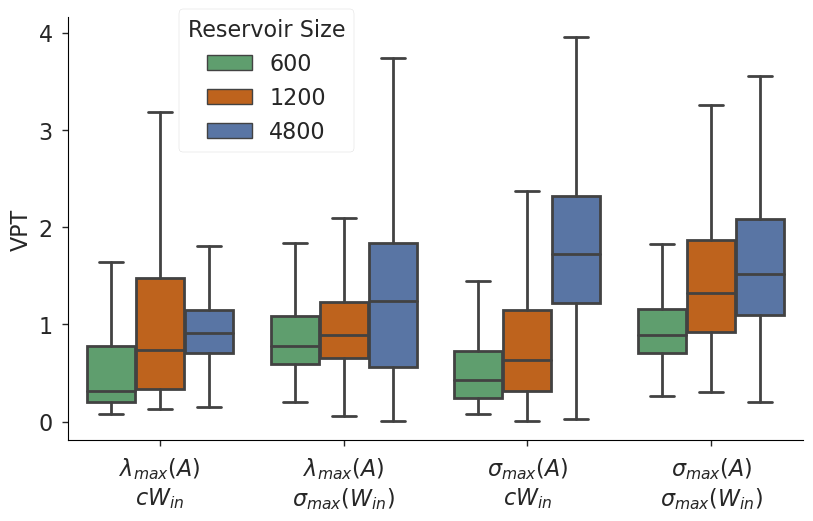

In [47]:
fig, ax = boxplot(
    ds.sel(experiment=[
        "eigA\nscaleWin", "eigA\nsvdWin",
        "svdA\nscaleWin", "svdA\nsvdWin",
    ]),
    x="experiment",
    y="vpt",
    hue="reservoir_dimension",
    showfliers=False,
    figsize=(8,5),
);
ax.legend(
    title=r"Reservoir Size",
    frameon=True,
    loc="center",
    bbox_to_anchor=(.27, .85),
)
ax.set(ylabel="VPT", yticks=np.arange(5))
ax.set(
    xticklabels=[
        r"$\lambda_{max}(A)$"+"\n"+r"$c W_{in}$",
        r"$\lambda_{max}(A)$"+"\n"+r"$\sigma_{max}(W_{in})$",
        r"$\sigma_{max}(A)$" +"\n"+r"$c W_{in}$",
        r"$\sigma_{max}(A)$" +"\n"+r"$\sigma_{max}(W_{in})$",
    ]
)
fig.savefig("../figures/matrix_normalization.pdf", bbox_inches="tight")